In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utility_functions import *

# Load features

In [3]:
data_features_df = pd.read_csv("data_features_df.csv")

In [4]:
feature_columns = [
    #'Date','Id',
    #'y','y_RawReturn','weight',
    'cum_return_prev5d','cum_return_prev21d','cum_return_prev63d','cum_return_prev1d',
    'cum_return_09:30_10:00', 'cum_return_10:00_11:30',
    'cum_return_11:30_13:30', 'cum_return_13:30_15:15',
    'relative_volume_15：30',
    'relative_volume_prev09:30_11:30', 'relative_volume_prev11:30_13:30',
    'relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00', 'relative_volume_10:00_11:30',
    'relative_volume_11:30_13:30', 'relative_volume_13:30_15:30',
    'volume_resid_return_corr','volume_raw_return_corr',
    'volatility_1d',
    'volatility_21d_raw','volatility_21d_resid',
    'volatility_63d_raw','volatility_63d_resid',
    'hlc_ratio','hlc_21mean',
    'skewness_1d','skewness_21d_resid','skewness_63d_resid',
]

# fill na - ffill

Use previous data to fill na

In [5]:
data_features_df = data_features_df.groupby('Id', group_keys=False).apply(lambda group: group.fillna(method='ffill'))

In [6]:
data_features_df = data_features_df.dropna()

# Save dropna data

In [6]:
data_features_df.to_csv('data_features_df_dropna.csv', index=False)

In [7]:
data_features_df = pd.read_csv('data_features_df_dropna.csv')

# Feature Correlation

## corr

In [7]:
correlation_matrix = data_features_df[['y'] + feature_columns].corr()

Corr sort by absolute value

In [8]:
correlation_matrix['y'].sort_values(key=lambda x: x.abs(), ascending=False)

y                                  1.000000
volatility_1d                     -0.136007
cum_return_09:30_10:00             0.120229
volatility_21d_raw                -0.065195
cum_return_prev5d                  0.040993
volatility_63d_raw                -0.031916
volatility_21d_resid              -0.029614
cum_return_prev21d                 0.019356
volatility_63d_resid              -0.016606
cum_return_13:30_15:15            -0.015077
skewness_1d                        0.012125
skewness_21d_resid                 0.011316
skewness_63d_resid                 0.010385
cum_return_prev63d                 0.009140
cum_return_10:00_11:30            -0.008094
volume_resid_return_corr           0.007530
volume_raw_return_corr             0.007404
hlc_ratio                         -0.007204
relative_volume_09:30_10:00       -0.005739
relative_volume_prev13:30_16:00    0.002935
relative_volume_15：30             -0.002800
relative_volume_10:00_11:30       -0.002124
relative_volume_13:30_15:30     

Plot the corr with y

In [9]:
correlation_with_y = correlation_matrix['y'].sort_values(ascending=False)

D:\ananconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


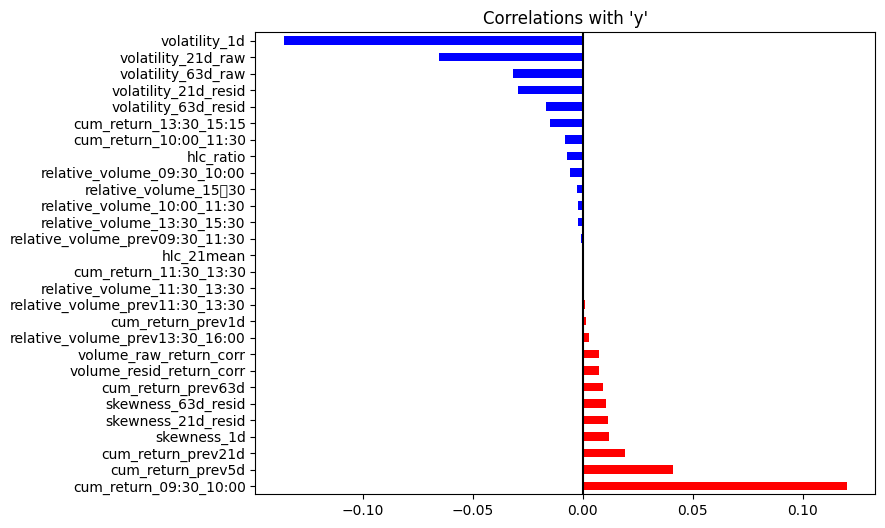

In [10]:
plt.figure(figsize=(8, 6))
correlation_with_y.drop('y').plot(kind='barh', color=(correlation_with_y.drop('y') > 0).map({True: 'red', False: 'blue'}))
plt.axvline(0, color='black')  # Neutral line at zero correlation
plt.title("Correlations with 'y'")
plt.show()

## weighted corr

In [11]:
def weighted_corr(x, y, w):
    x_mean = np.average(x, weights=w)
    y_mean = np.average(y, weights=w)
    
    cov_xy = np.sum(w * (x - x_mean) * (y - y_mean))
    var_x = np.sum(w * (x - x_mean) ** 2)
    var_y = np.sum(w * (y - y_mean) ** 2)
    
    return cov_xy / np.sqrt(var_x * var_y)

In [12]:
weighted_corrs = {}
for col in feature_columns:
    weighted_corrs[col] = weighted_corr(
        data_features_df[col].to_numpy(),
        data_features_df['y'].to_numpy(),
        data_features_df['weight'].to_numpy()
    )
weighted_corrs = pd.Series(weighted_corrs).sort_values(ascending=False)

In [13]:
weighted_corrs.sort_values(key=lambda x: x.abs(), ascending=False)

volatility_1d                     -0.122444
cum_return_09:30_10:00             0.109204
volatility_21d_raw                -0.076873
cum_return_prev5d                  0.035021
volatility_63d_raw                -0.033469
volatility_21d_resid              -0.026169
cum_return_prev21d                 0.017414
cum_return_13:30_15:15            -0.015255
volatility_63d_resid              -0.014022
skewness_1d                        0.012392
skewness_21d_resid                 0.011508
skewness_63d_resid                 0.010475
cum_return_prev63d                 0.008480
hlc_ratio                         -0.007782
volume_raw_return_corr             0.007644
volume_resid_return_corr           0.007233
relative_volume_09:30_10:00       -0.005688
cum_return_10:00_11:30            -0.005279
relative_volume_prev13:30_16:00    0.003809
relative_volume_15：30             -0.002875
relative_volume_10:00_11:30       -0.002271
relative_volume_13:30_15:30       -0.002211
cum_return_prev1d               

D:\ananconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


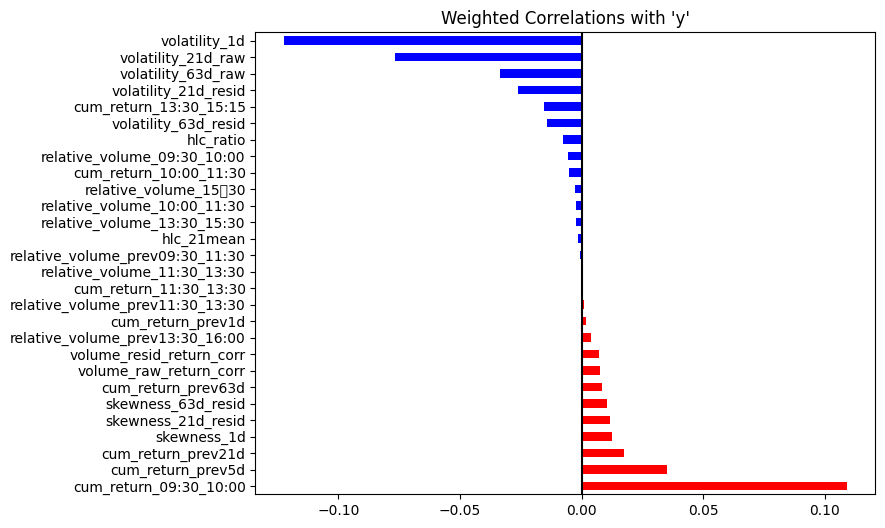

In [14]:
# Plot correlation coefs
plt.figure(figsize=(8, 6))
weighted_corrs.plot(kind='barh', color=(weighted_corrs > 0).map({True: 'red', False: 'blue'}))
plt.axvline(0, color='black') # Neutral line at zero correlation
plt.title("Weighted Correlations with 'y'")
plt.show()

Weighted corr and corr have similar results

## plot correlation matrix

D:\ananconda\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ananconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


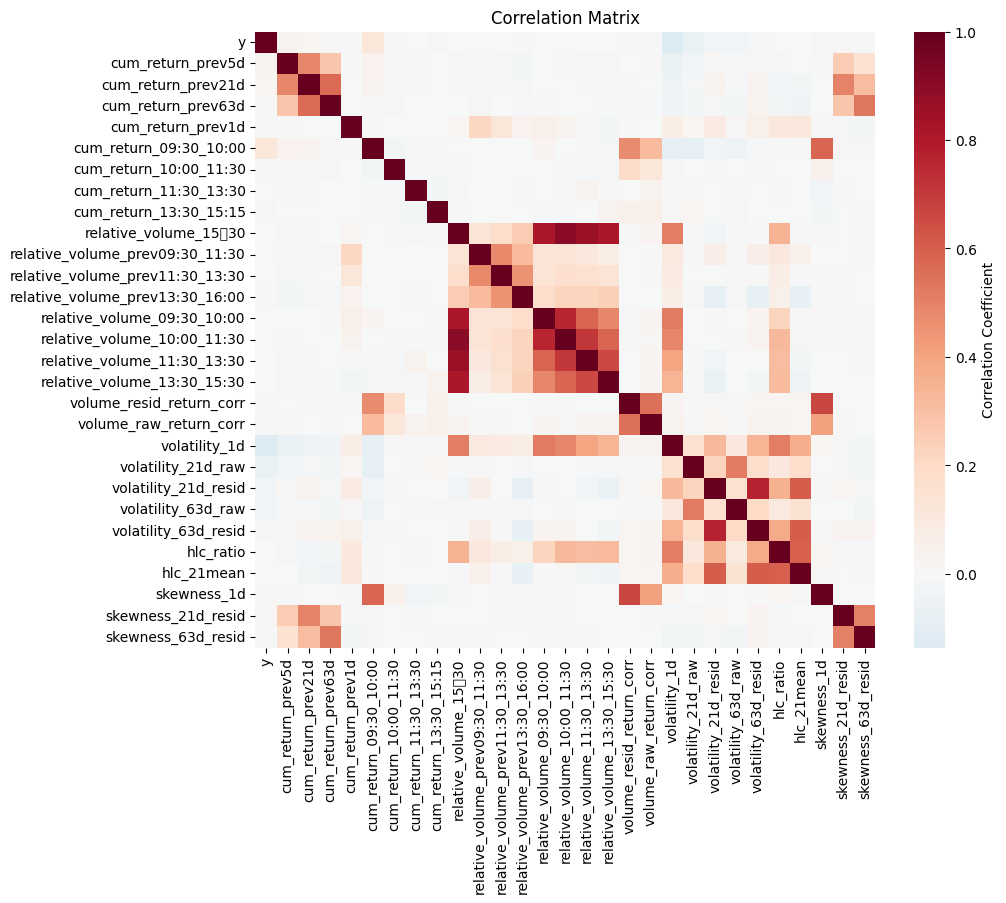

In [16]:
# Plot the full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', center=0, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix")
plt.show()

# Factor backtest

## Functions

Functions for calculate weighted quantile and quantile returns

In [17]:
def factor_quantile_weighted(input_df, factor_column, weight_column, n_quantile=10):
    """
    Calculate factor quantile group for every day
    """
    if 'Date' not in input_df.columns or 'Id' not in input_df.columns:
        raise ValueError("Input DataFrame must contain 'Date' and 'Id' columns.")

    input_df = input_df.sort_values(['Date', factor_column])
    
    def calculate_weighted_quantiles(group):
        group = group.sort_values(factor_column).copy()
        total_weight = group[weight_column].sum()
        bin_size = total_weight / n_quantile
        # Use cumsum to calculate quantile group
        group['cumulative_weight'] = group[weight_column].cumsum()
        # Calculate quantile group
        group[f'{factor_column}_quantile'] = np.floor(group['cumulative_weight'] / bin_size).astype(int)
        group[f'{factor_column}_quantile'] = group[f'{factor_column}_quantile'].clip(upper=n_quantile-1)
        # Clear helping column
        group.drop(columns='cumulative_weight', inplace=True)
        return group

    # Calculate weighted quantile group for every day
    output_df = (
        input_df
        .groupby('Date', group_keys=False)
        .apply(calculate_weighted_quantiles)
        .reset_index(drop=True)
    )
    
    # Sort by date and id
    output_df['Date'] = pd.to_datetime(output_df['Date'])
    output_df = output_df.sort_values(['Date', 'Id']).reset_index(drop=True)

    return output_df

In [18]:
def factor_return_weighted(quantile_df, factor_column, weight_column, n_quantile=10):
    """
    Calculate weighted returns for every quantile
    """
    quantile_column = f"{factor_column}_quantile"

    if quantile_column not in quantile_df.columns or 'y' not in quantile_df.columns or 'Date' not in quantile_df.columns:
        raise ValueError(f"Columns {quantile_column} and 'y' and 'Date' must exist in the input DataFrame.")

    if weight_column not in quantile_df.columns:
        raise ValueError(f"Weight column {weight_column} must exist in the input DataFrame.")

    result = (
        quantile_df.groupby(['Date', quantile_column])
        .apply(lambda x: np.average(x['y'], weights=x[weight_column]))
        .unstack(fill_value=0)
    ).reindex(columns=range(n_quantile)).reset_index()
    
    result['19LS'] = result[9] - result[0]
    result['33LS'] = result[9] + result[8] + result[7] - result[0] - result[1] - result[2]
    
    return result

## Backtest

Weighted factor backtest for every feature

Feature cum_return_prev5d sign: 1


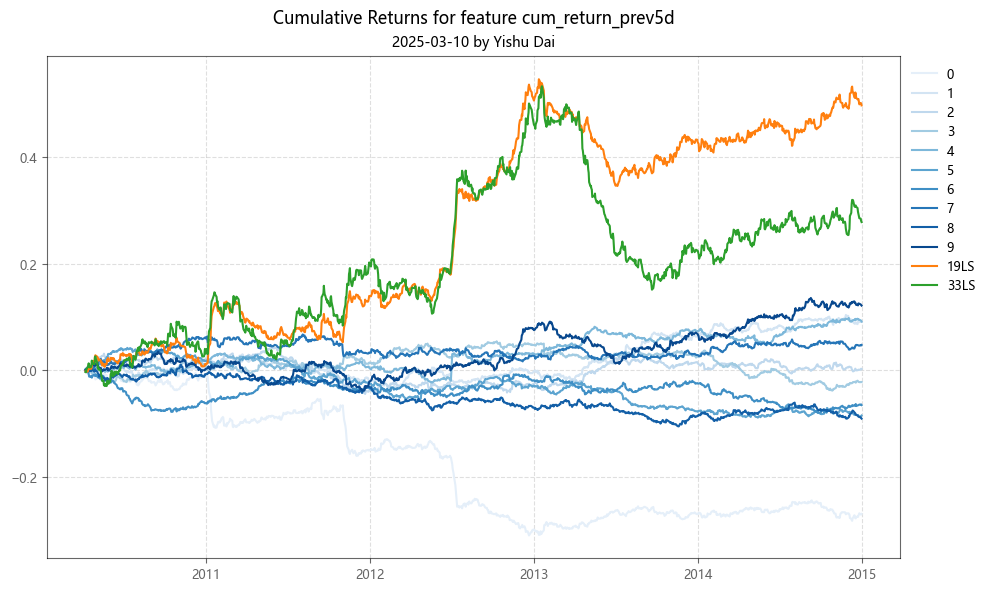

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -6.31%      -31.01%           5.21%         -1.21
1             1.9%       -6.11%           3.26%          0.58
2            0.09%       -8.39%           3.07%          0.03
3           -0.44%        -8.7%           2.92%         -0.15
4            1.92%       -5.28%            3.5%          0.55
5           -1.83%      -12.43%           2.87%         -0.64
6           -1.38%       -7.81%           2.93%         -0.47
7            1.02%       -4.68%           2.96%          0.34
8           -1.95%      -11.37%           3.17%         -0.62
9            2.52%       -7.26%            3.9%          0.65
19LS         9.12%      -12.89%           6.52%          1.40
33LS         5.76%      -24.72%           9.15%          0.63

Feature cum_return_prev21d sign: 1


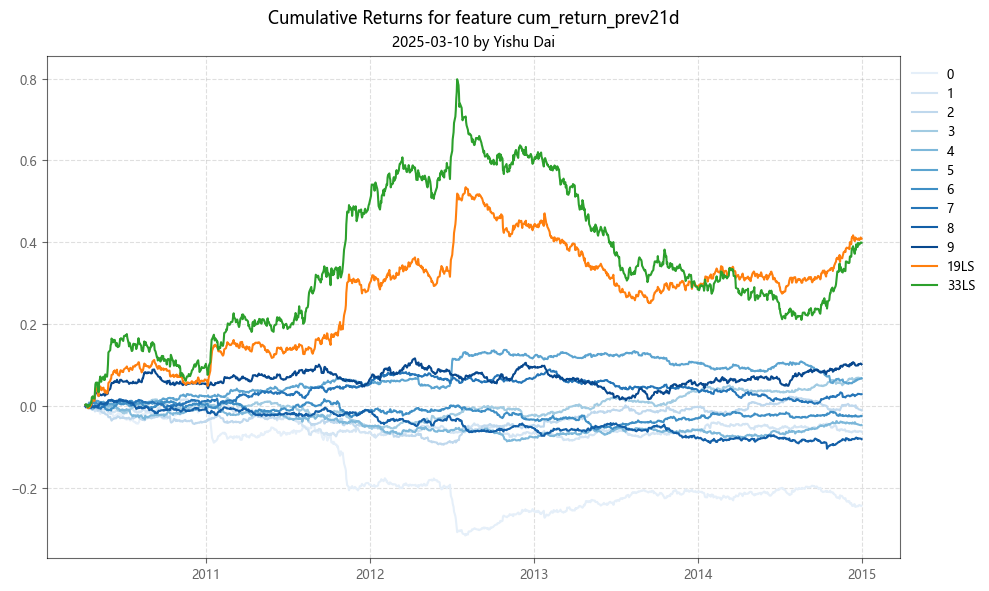

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -5.57%       -31.7%            5.9%         -0.94
1           -1.31%       -9.79%           3.36%         -0.39
2           -0.18%       -9.43%           3.11%         -0.06
3            1.44%       -7.45%            2.8%          0.51
4           -0.97%       -8.93%           2.83%         -0.34
5            1.44%       -7.24%           3.47%          0.41
6           -0.49%       -7.31%           2.78%         -0.18
7            0.63%       -7.67%           2.73%          0.23
8           -1.73%      -11.72%           3.07%         -0.56
9            2.15%       -9.08%           4.04%          0.53
19LS         7.79%      -18.27%           7.26%          1.07
33LS         7.91%      -32.15%          10.24%          0.77

Feature cum_return_prev63d sign: 1


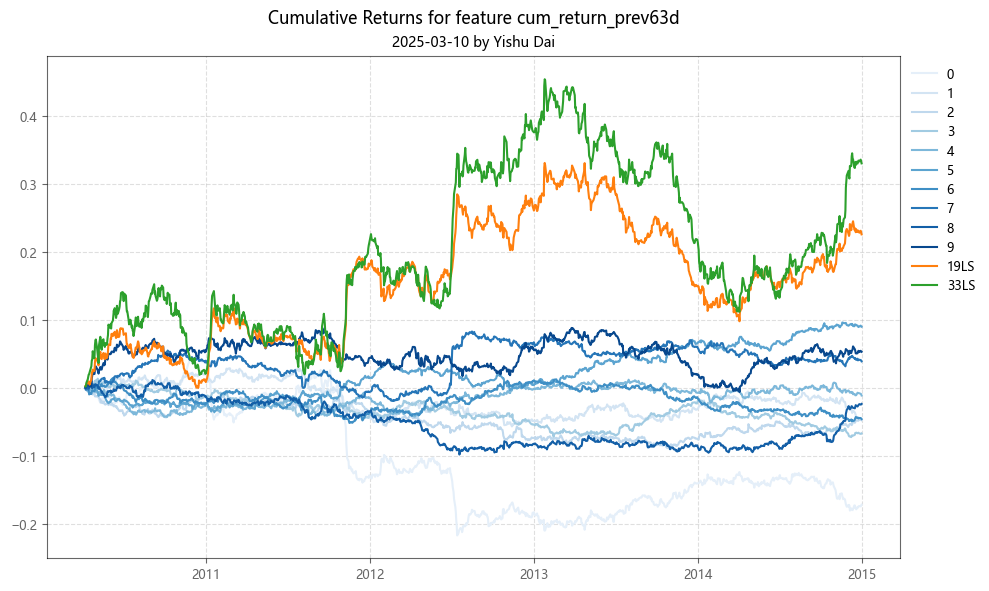

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -3.72%       -24.7%           5.89%         -0.63
1           -0.96%       -8.17%           3.47%         -0.28
2           -0.94%       -8.74%           2.98%         -0.32
3           -1.41%       -8.31%            2.7%         -0.52
4            -0.2%       -4.38%           2.59%         -0.08
5            1.87%        -4.1%           2.66%          0.70
6           -0.94%       -6.45%           2.55%         -0.37
7            0.88%       -6.96%           3.65%          0.24
8           -0.44%      -10.72%           3.21%         -0.14
9             1.2%       -8.56%           4.44%          0.27
19LS         4.71%      -17.25%           7.83%          0.60
33LS         6.87%      -23.05%          11.18%          0.61

Feature cum_return_prev1d sign: 1


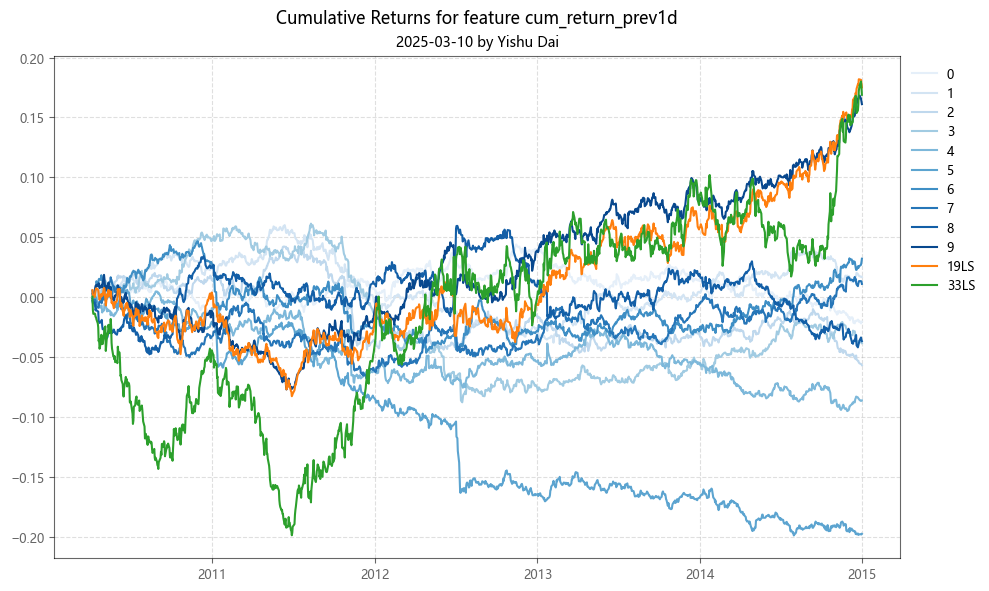

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            -0.4%       -6.25%           2.71%         -0.15
1            0.39%       -9.18%           2.73%          0.14
2           -1.18%       -9.35%           2.92%         -0.41
3           -0.78%      -13.99%           3.11%         -0.25
4           -1.83%       -9.73%           3.26%         -0.56
5           -4.48%      -20.32%           3.44%         -1.31
6            0.73%       -8.79%            3.5%          0.21
7            0.29%       -8.24%           3.36%          0.09
8           -0.68%       -9.38%           4.69%         -0.14
9            3.33%       -9.28%           4.88%          0.68
19LS         3.64%       -8.78%            5.9%          0.62
33LS         3.84%      -19.48%           9.77%          0.39

Feature cum_return_09:30_10:00 sign: 1


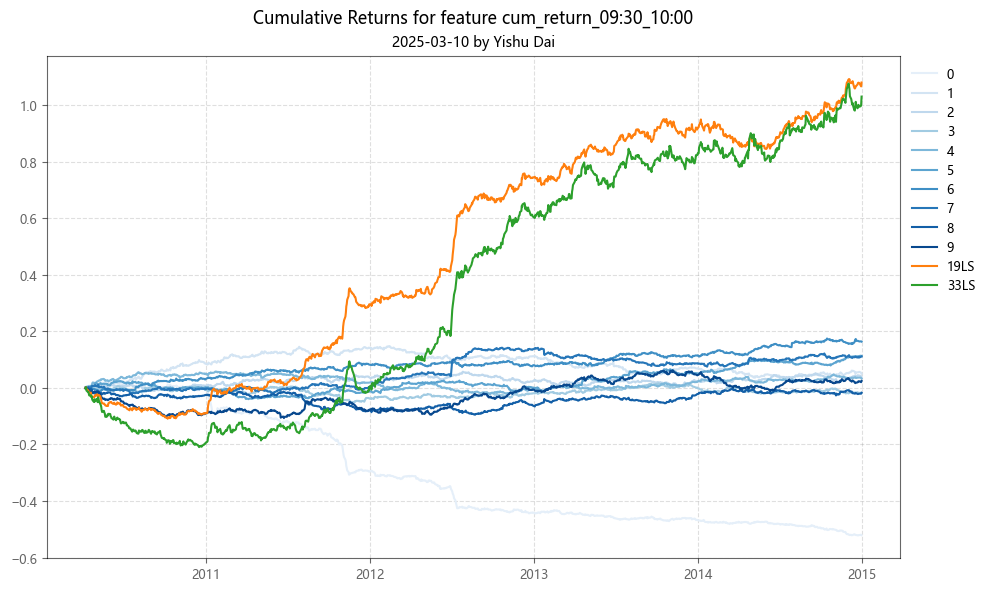

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0          -14.25%      -52.98%           5.24%         -2.72
1             1.1%      -10.32%           3.36%          0.33
2            0.85%        -4.8%           2.97%          0.29
3           -0.34%       -5.68%           2.79%         -0.12
4            0.73%       -7.58%           2.71%          0.27
5            2.32%       -6.21%           2.68%          0.87
6            3.29%       -1.84%           2.74%          1.20
7            2.32%       -5.79%           3.92%          0.59
8           -0.31%       -9.43%           3.43%         -0.09
9             0.6%      -10.49%           4.27%          0.14
19LS        16.98%      -11.06%           6.74%          2.52
33LS        16.73%      -20.92%          10.24%          1.63

Feature cum_return_10:00_11:30 sign: 1


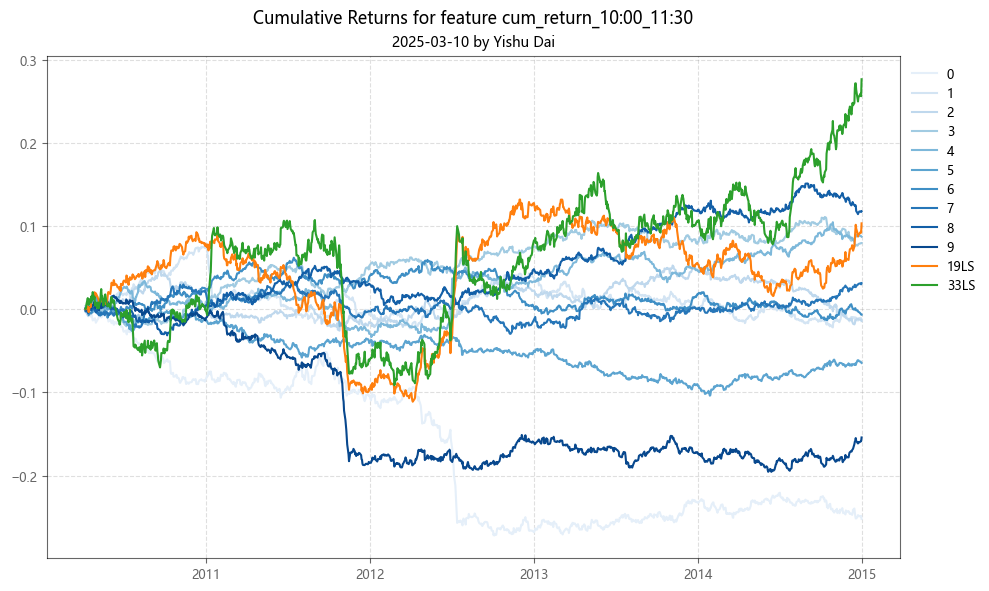

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -5.83%      -27.15%           5.02%         -1.16
1           -0.21%       -9.05%           3.41%         -0.06
2           -0.25%       -6.88%           3.04%         -0.08
3            1.67%       -3.64%           2.86%          0.59
4            1.85%       -6.47%            3.7%          0.50
5           -1.36%      -11.55%           2.73%         -0.50
6            -0.1%       -6.93%           2.73%         -0.04
7             0.7%       -6.26%           2.92%          0.24
8            2.43%       -4.46%           3.08%          0.79
9           -3.38%      -20.55%           4.33%         -0.78
19LS         2.33%       -18.4%           6.76%          0.34
33LS         5.78%      -17.64%            9.6%          0.60

Feature cum_return_11:30_13:30 sign: -1


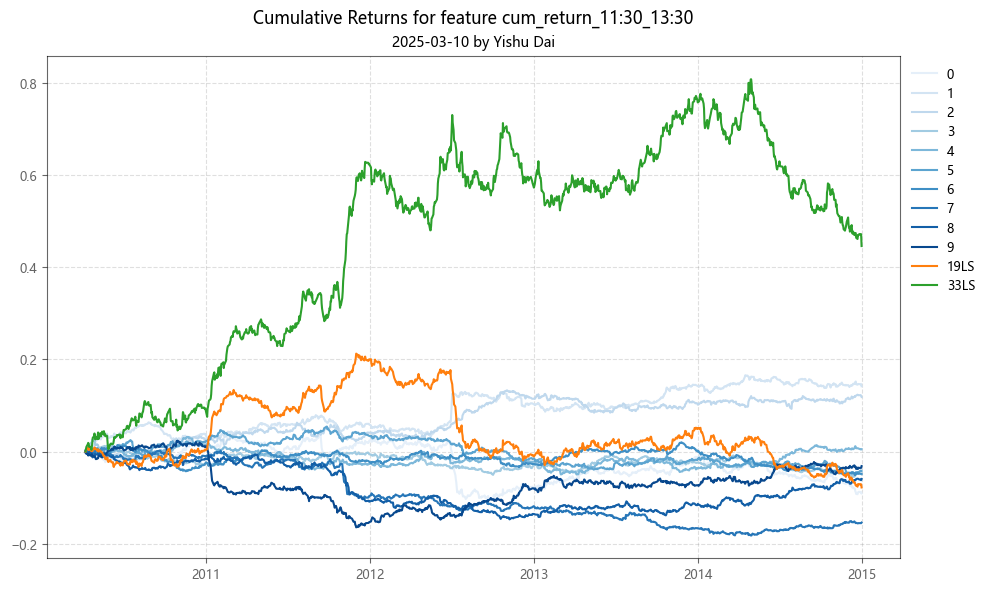

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -1.89%      -13.33%           4.62%         -0.41
1            2.92%       -4.27%           4.08%          0.72
2            2.44%       -4.28%           3.19%          0.77
3           -1.03%       -7.68%           2.81%         -0.37
4            0.15%       -7.81%            3.1%          0.05
5           -0.86%       -9.58%           2.96%         -0.29
6            -1.0%       -6.94%           2.71%         -0.37
7           -3.43%      -18.43%           3.12%         -1.10
8           -1.24%      -14.51%           3.28%         -0.38
9           -0.58%      -18.26%            4.3%         -0.14
19LS         -1.5%      -23.47%            6.4%         -0.23
33LS         8.62%      -19.83%           9.85%          0.88

Feature cum_return_13:30_15:15 sign: -1


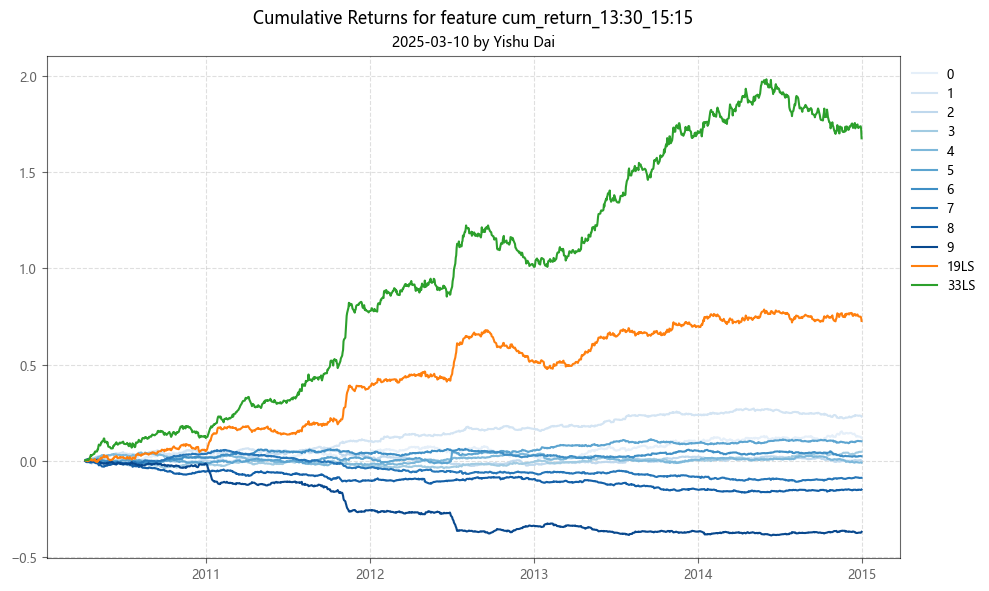

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            2.48%       -6.26%           4.41%          0.56
1            4.51%       -4.05%           3.28%          1.38
2            0.03%       -7.97%            3.0%          0.01
3            1.01%       -4.26%           2.95%          0.34
4           -0.18%       -6.38%           2.75%         -0.06
5            2.11%       -3.19%           3.64%          0.58
6            0.52%       -4.72%           2.81%          0.18
7           -1.91%      -15.56%            2.9%         -0.66
8           -3.32%      -16.24%           3.27%         -1.02
9           -9.16%       -39.0%           5.23%         -1.75
19LS        12.49%      -11.97%           6.94%          1.80
33LS        23.71%      -10.09%           9.88%          2.40

Feature relative_volume_15：30 sign: 1


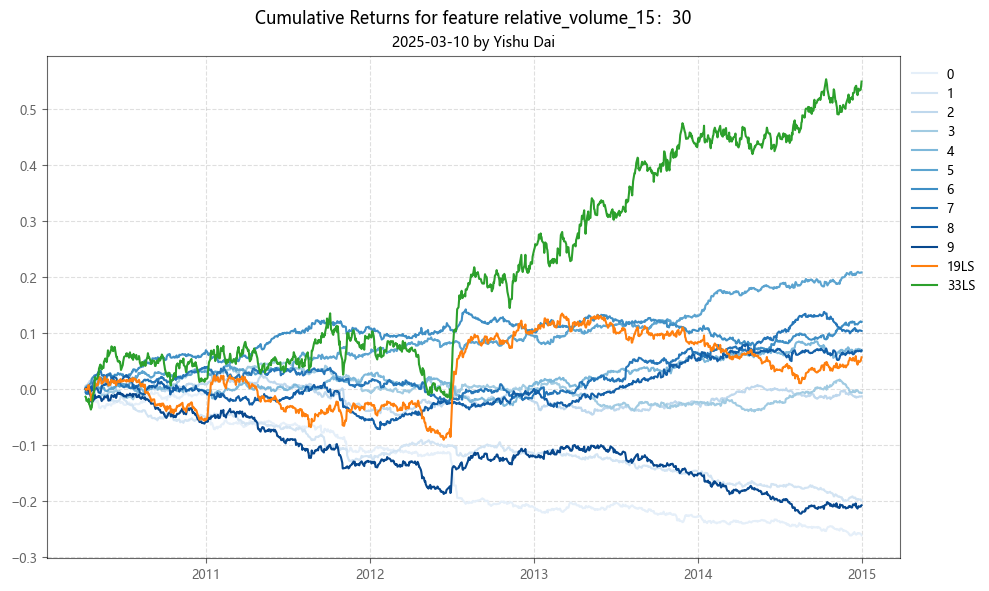

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -6.15%       -26.0%           3.61%         -1.70
1           -4.56%      -20.66%           2.88%         -1.58
2           -0.24%       -7.21%           2.78%         -0.09
3           -0.11%       -8.63%           2.89%         -0.04
4            1.45%       -5.75%           2.97%          0.49
5            4.12%        -2.4%           2.95%          1.40
6            2.47%       -6.36%           3.13%          0.79
7            2.17%       -6.24%           3.54%          0.61
8            1.49%       -9.31%           3.82%          0.39
9           -4.68%      -21.91%           5.34%         -0.88
19LS         1.41%      -10.98%           6.87%          0.20
33LS        10.23%      -13.07%           9.85%          1.04

Feature relative_volume_prev09:30_11:30 sign: -1


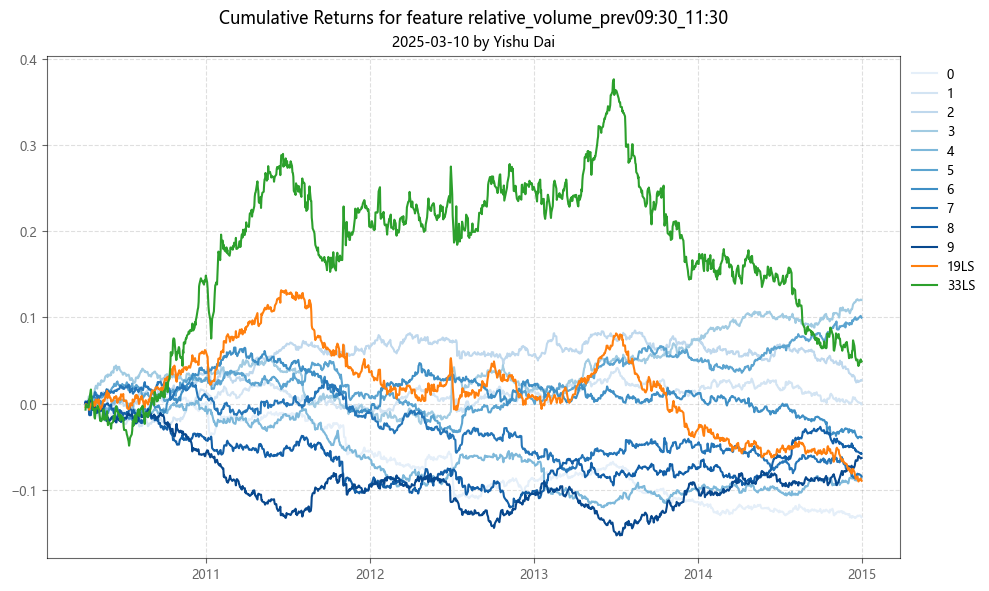

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -2.89%      -13.77%            3.2%         -0.90
1            0.02%        -4.0%           2.74%          0.01
2            0.61%       -5.51%           3.07%          0.20
3             2.5%       -7.15%           3.78%          0.66
4           -1.83%      -12.38%           3.23%         -0.57
5            2.07%       -7.83%           3.13%          0.66
6           -0.79%       -9.67%           3.43%         -0.23
7           -1.78%      -10.84%           3.75%         -0.47
8           -1.18%      -12.08%            3.9%         -0.30
9           -1.28%      -15.43%            4.2%         -0.31
19LS        -1.82%      -19.18%           5.46%         -0.33
33LS         1.45%      -23.76%           9.27%          0.16

Feature relative_volume_prev11:30_13:30 sign: 1


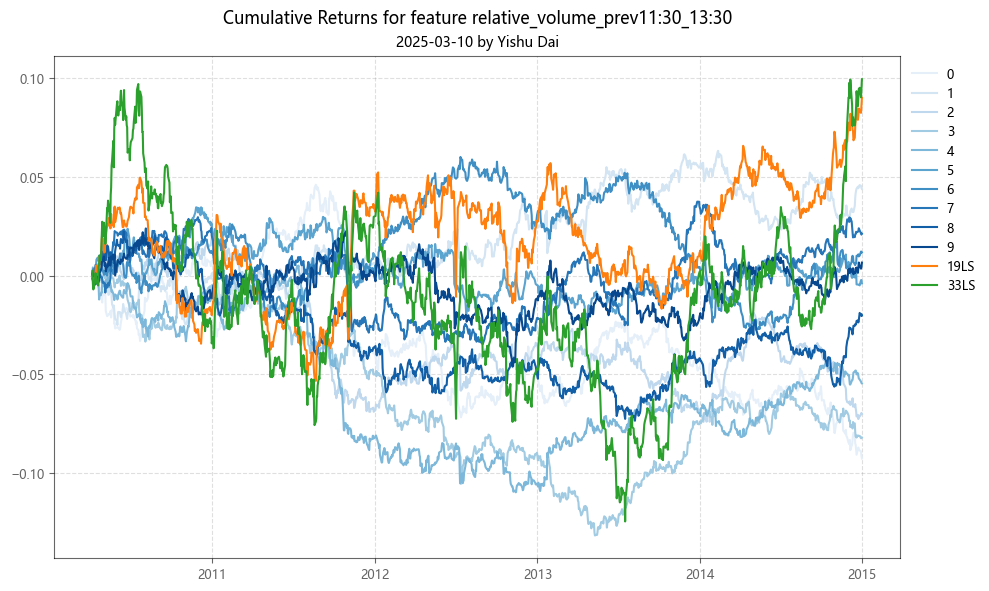

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -1.94%      -12.97%           4.22%         -0.46
1            0.97%       -3.77%           3.28%          0.29
2           -1.47%       -9.38%           3.19%         -0.46
3           -1.74%      -13.56%           3.18%         -0.55
4           -1.13%      -11.34%           3.18%         -0.35
5           -0.03%       -5.27%           3.22%         -0.01
6            0.29%       -8.16%           3.13%          0.09
7            0.51%       -6.14%           3.45%          0.15
8           -0.37%       -9.36%           3.34%         -0.11
9            0.21%       -6.67%           3.71%          0.06
19LS         2.01%       -9.66%           5.75%          0.35
33LS         2.44%      -19.12%           9.01%          0.27

Feature relative_volume_prev13:30_16:00 sign: 1


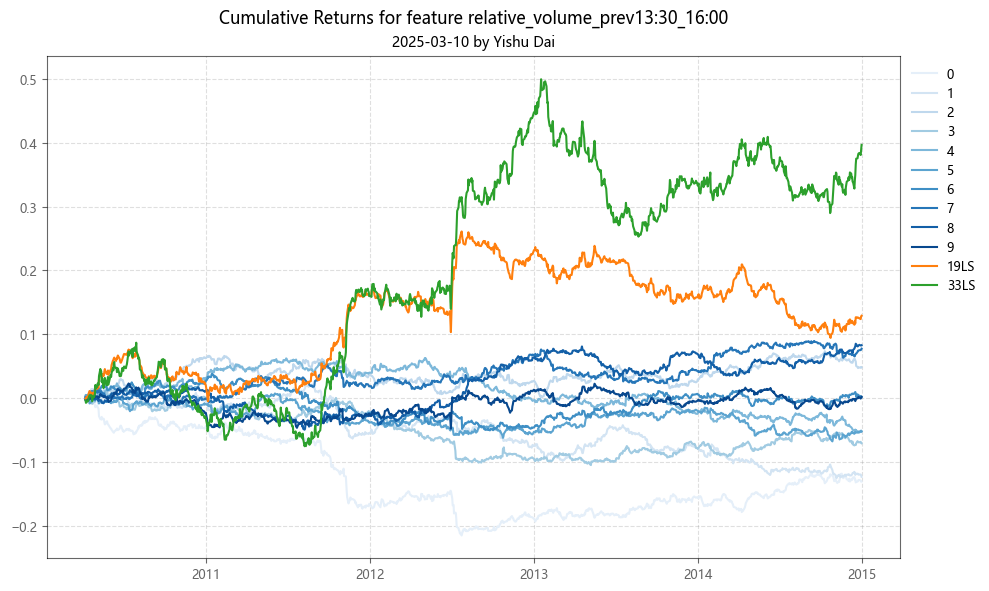

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -2.82%      -21.15%            4.4%         -0.64
1           -2.68%      -14.21%           3.63%         -0.74
2            1.05%       -6.02%           3.32%          0.32
3           -1.48%      -11.15%           3.36%         -0.44
4           -1.07%      -10.82%           3.14%         -0.34
5           -1.08%       -7.31%           3.12%         -0.35
6            0.08%       -8.46%           3.19%          0.02
7            1.64%        -4.9%           3.05%          0.54
8            1.74%        -6.5%           3.11%          0.56
9            0.13%       -6.78%           4.21%          0.03
19LS         2.81%      -12.98%           6.51%          0.43
33LS          7.8%      -16.25%            9.6%          0.81

Feature relative_volume_09:30_10:00 sign: -1


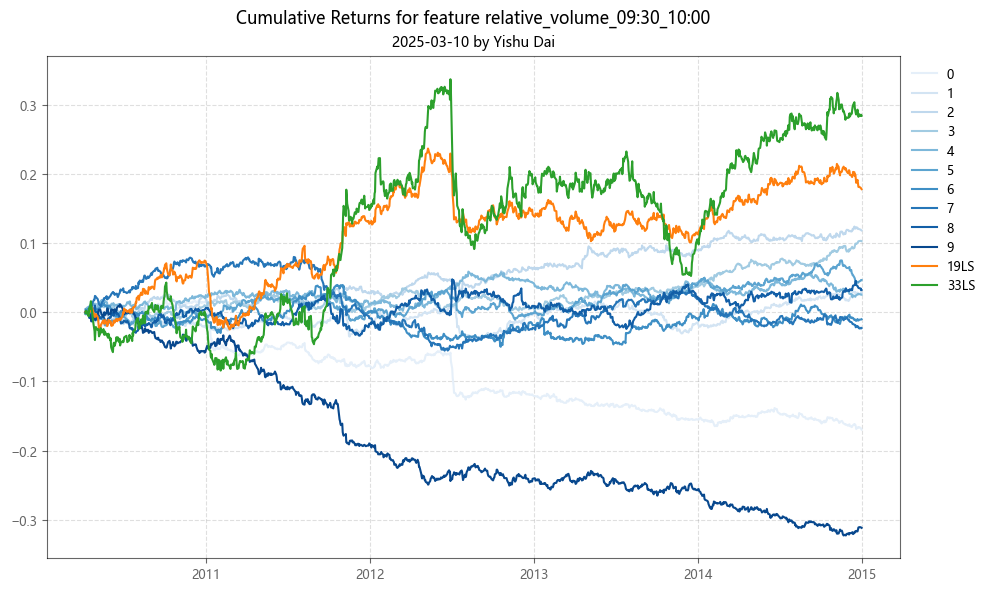

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            -3.8%      -18.24%           3.07%         -1.24
1            0.62%       -4.72%           2.72%          0.23
2            2.42%        -2.6%           2.63%          0.92
3            2.12%       -3.26%           2.62%          0.81
4            0.57%        -4.0%           2.73%          0.21
5            1.02%       -4.16%           3.19%          0.32
6           -0.15%       -8.54%            3.6%         -0.04
7           -0.42%      -12.46%           3.59%         -0.12
8            0.79%       -6.74%           4.92%          0.16
9           -7.47%      -32.66%           4.78%         -1.56
19LS          3.7%      -10.68%           6.04%          0.61
33LS         5.98%      -20.46%          10.36%          0.58

Feature relative_volume_10:00_11:30 sign: 1


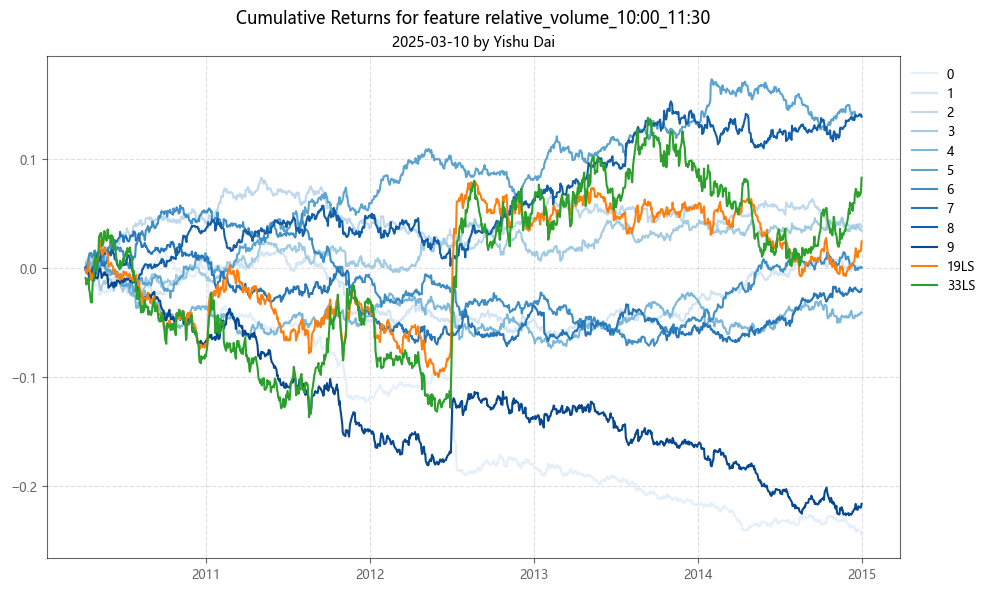

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -5.73%      -25.37%           3.41%         -1.68
1            0.04%       -7.74%           2.81%          0.01
2            0.82%        -6.0%            2.9%          0.28
3            0.76%       -3.68%           2.94%          0.26
4           -0.83%       -8.35%           3.17%         -0.26
5            2.84%       -4.06%           3.21%          0.88
6            0.06%      -12.06%           3.33%          0.02
7           -0.35%      -10.08%           3.51%         -0.10
8            2.87%       -5.13%            3.9%          0.74
9            -4.9%      -22.37%            5.2%         -0.94
19LS         0.73%      -11.91%           6.62%          0.11
33LS         2.18%      -16.25%           9.74%          0.22

Feature relative_volume_11:30_13:30 sign: 1


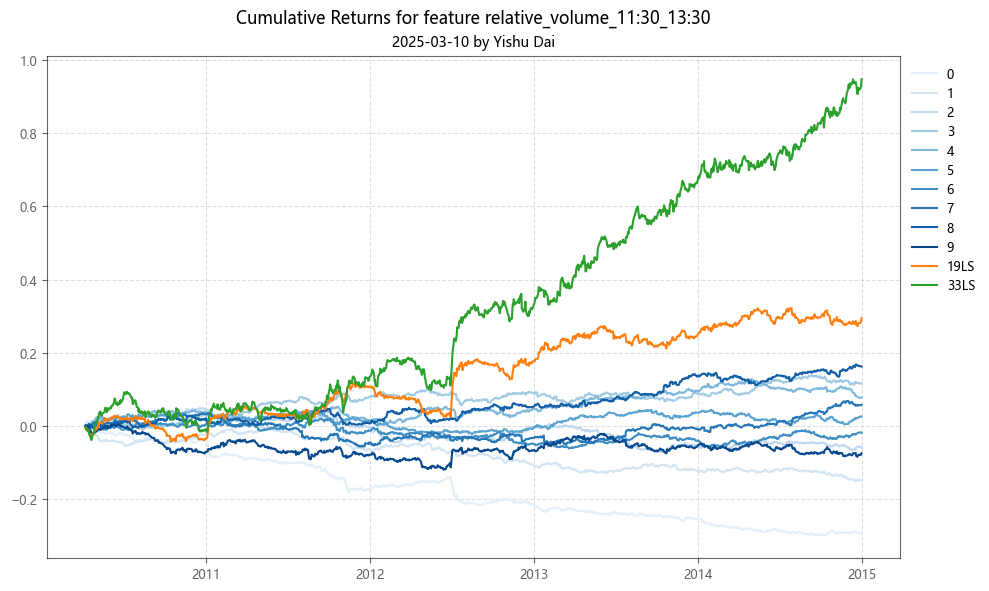

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -7.07%      -30.63%            3.6%         -1.96
1            -3.3%      -14.87%           3.14%         -1.05
2           -1.24%       -11.4%           2.93%         -0.42
3             2.4%        -4.4%           3.05%          0.79
4            1.65%       -4.54%           3.16%          0.52
5            0.57%       -6.14%           2.95%          0.19
6           -0.35%       -7.96%           3.09%         -0.11
7            1.26%       -8.85%           3.65%          0.35
8             3.3%       -4.22%           3.67%          0.90
9            -1.5%      -12.14%           5.03%         -0.30
19LS         5.83%       -8.22%            6.6%          0.88
33LS        15.65%       -9.82%           9.74%          1.61

Feature relative_volume_13:30_15:30 sign: 1


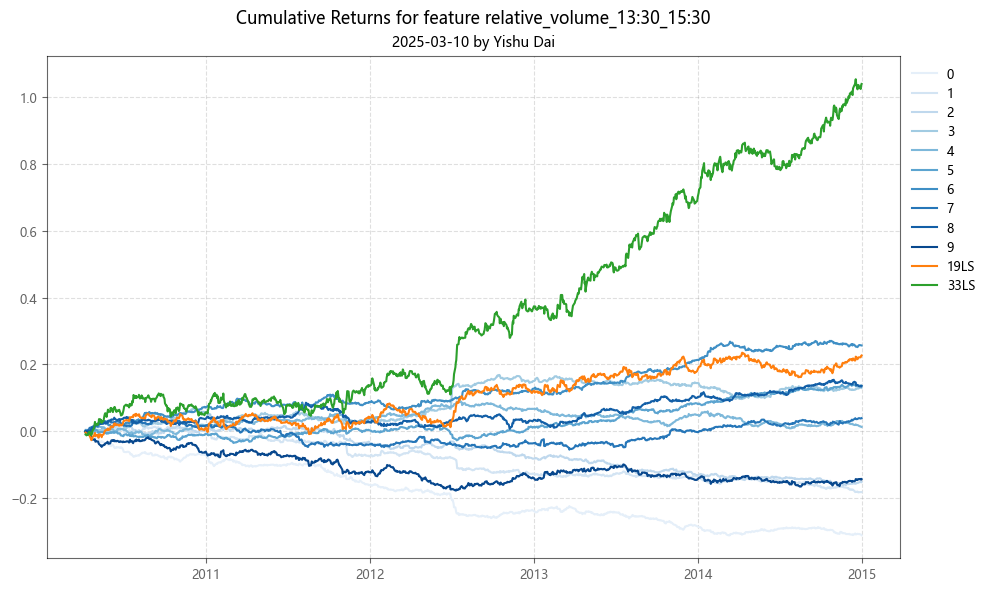

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -7.53%      -31.62%           3.76%         -2.00
1           -4.12%      -19.33%           3.35%         -1.23
2           -3.39%       -17.7%           2.99%         -1.13
3            2.68%       -6.14%           3.97%          0.68
4             0.3%       -7.46%           2.85%          0.10
5            2.75%       -4.59%           2.83%          0.97
6            4.99%       -4.06%           3.08%          1.62
7            0.86%        -9.1%           3.34%          0.26
8            2.78%        -7.1%           3.66%          0.76
9           -3.13%      -17.38%           4.77%         -0.66
19LS          4.6%       -6.48%           6.21%          0.74
33LS        16.78%       -6.24%           9.57%          1.75

Feature volume_resid_return_corr sign: 1


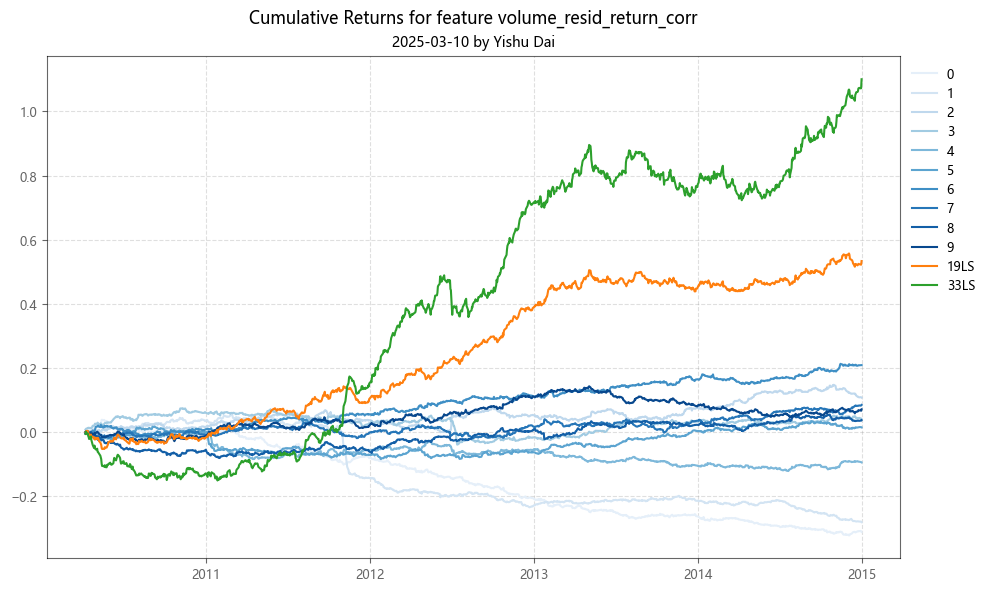

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -7.49%      -34.53%           3.57%         -2.10
1           -6.64%      -31.49%           3.75%         -1.77
2            2.27%       -6.41%           4.11%          0.55
3            0.91%      -10.44%            3.4%          0.27
4           -2.01%      -12.18%           3.39%         -0.59
5            0.37%       -9.91%           3.16%          0.12
6            4.14%       -3.27%           3.04%          1.36
7            1.79%        -4.7%           3.18%          0.56
8            0.84%        -8.1%            3.5%          0.24
9            1.53%        -8.5%           3.59%          0.43
19LS          9.6%       -5.61%           5.28%          1.82
33LS        17.45%      -14.92%           9.08%          1.92

Feature volume_raw_return_corr sign: 1


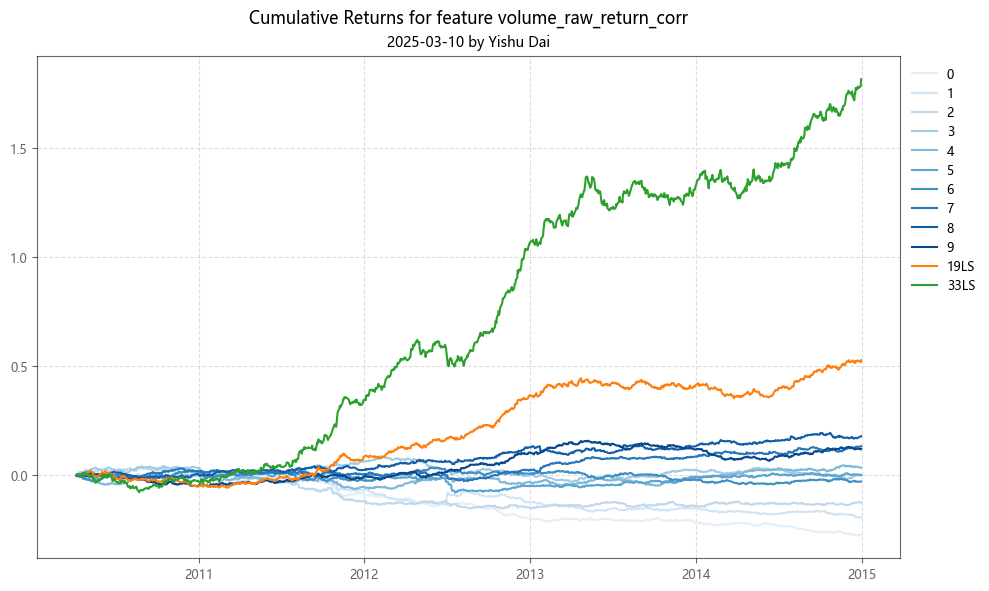

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -6.51%      -28.31%           3.57%         -1.82
1           -4.37%      -20.31%            4.0%         -1.09
2           -2.72%       -17.9%           3.52%         -0.77
3            0.03%      -10.75%           3.12%          0.01
4             0.8%       -6.56%           3.46%          0.23
5            0.11%       -9.67%           3.48%          0.03
6           -0.55%       -7.33%           3.25%         -0.17
7            2.74%       -5.66%           3.39%          0.81
8            3.62%       -3.47%            3.5%          1.03
9            2.52%       -7.91%           3.48%          0.72
19LS          9.5%       -7.62%           5.11%          1.86
33LS        24.93%       -8.38%           8.95%          2.78

Feature volatility_1d sign: -1


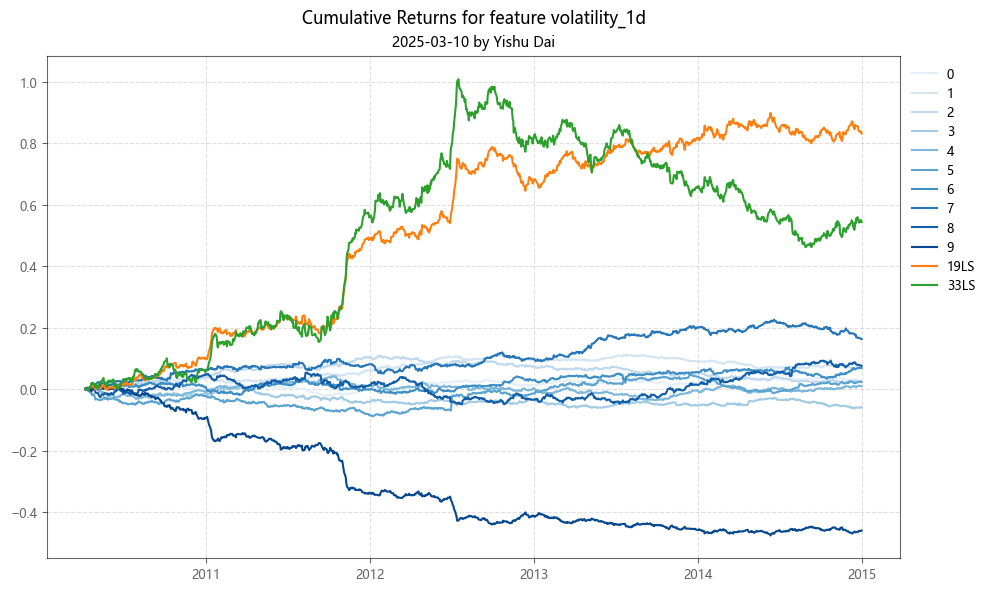

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            0.62%       -4.75%           1.86%          0.33
1            1.45%       -4.05%           2.18%          0.67
2            0.53%       -8.03%           2.22%          0.24
3           -1.26%       -7.51%           2.41%         -0.52
4            0.24%       -7.48%           2.74%          0.09
5            0.55%       -8.95%           3.72%          0.15
6            1.46%       -4.89%           3.13%          0.46
7             3.3%       -5.16%           3.58%          0.92
8            1.66%       -9.69%           4.51%          0.37
9           -12.0%       -47.8%           6.28%         -1.91
19LS        13.87%       -7.89%            6.7%          2.07
33LS        10.15%      -26.61%          10.07%          1.01

Feature volatility_21d_raw sign: -1


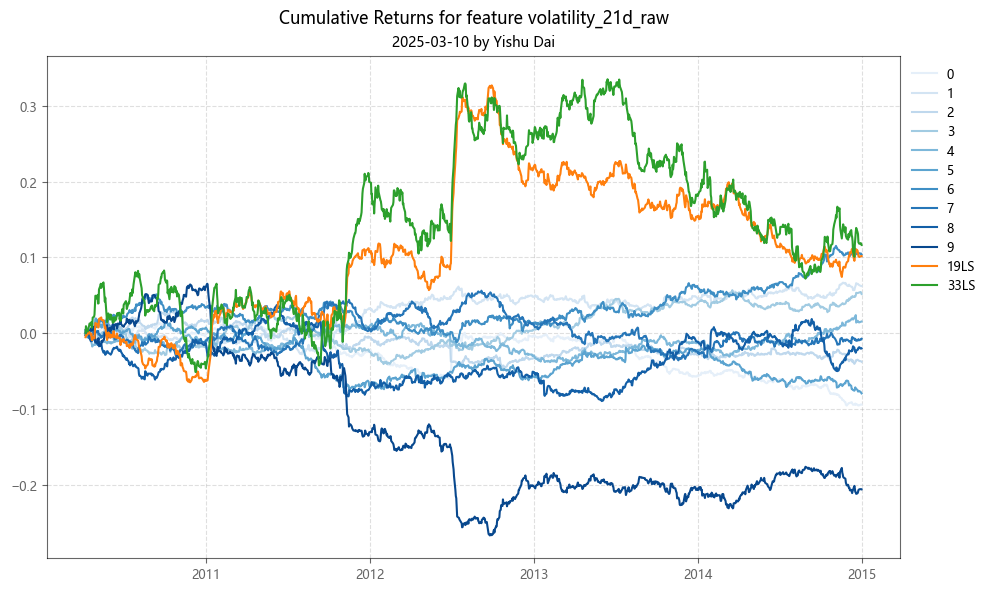

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -2.02%      -10.96%           3.23%         -0.63
1            1.31%       -4.05%           2.38%          0.55
2           -0.77%       -7.22%           2.78%         -0.28
3            1.11%       -6.88%           2.63%          0.42
4            0.36%       -5.05%           2.75%          0.13
5           -1.69%       -9.54%           3.01%         -0.56
6            2.16%       -5.94%           3.18%          0.68
7            -0.1%       -8.65%           3.49%         -0.03
8           -0.33%      -12.02%           4.48%         -0.07
9           -4.59%      -30.92%           5.94%         -0.77
19LS         2.32%      -18.78%            7.0%          0.33
33LS          2.9%      -19.36%          10.34%          0.28

Feature volatility_21d_resid sign: -1


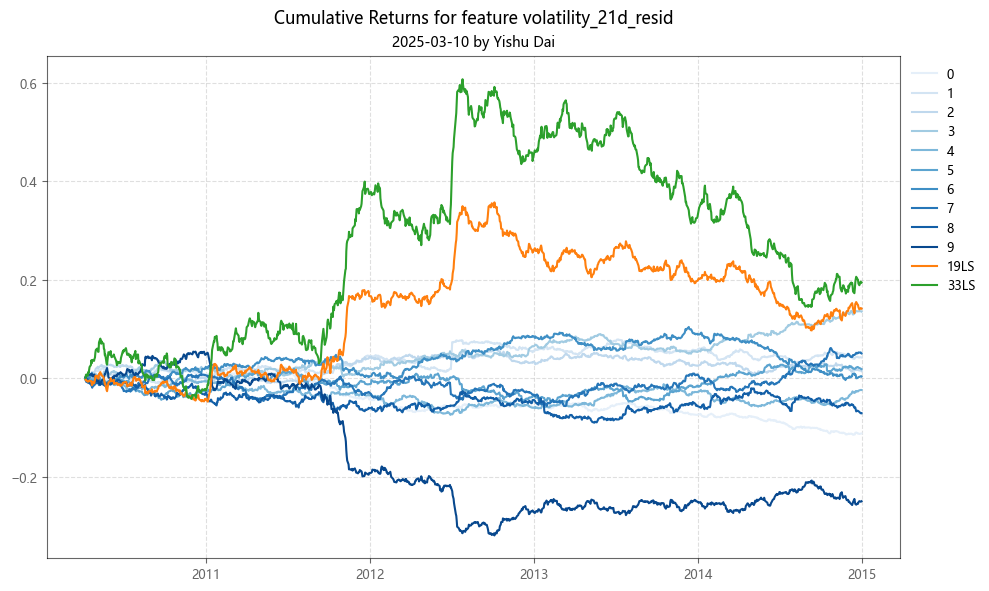

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -2.46%      -13.03%            2.0%         -1.23
1            0.93%       -4.42%           3.27%          0.28
2            0.33%        -5.0%           2.37%          0.14
3            2.76%       -3.65%           2.66%          1.04
4           -0.47%       -7.63%           2.74%         -0.17
5            0.44%        -6.6%            3.1%          0.14
6            0.13%       -9.73%           3.32%          0.04
7            1.11%       -6.33%           3.66%          0.30
8           -1.46%       -8.89%           4.12%         -0.35
9            -5.7%       -35.1%           6.13%         -0.93
19LS         3.05%      -18.91%           6.51%          0.47
33LS         4.35%      -28.25%          10.08%          0.43

Feature volatility_63d_raw sign: -1


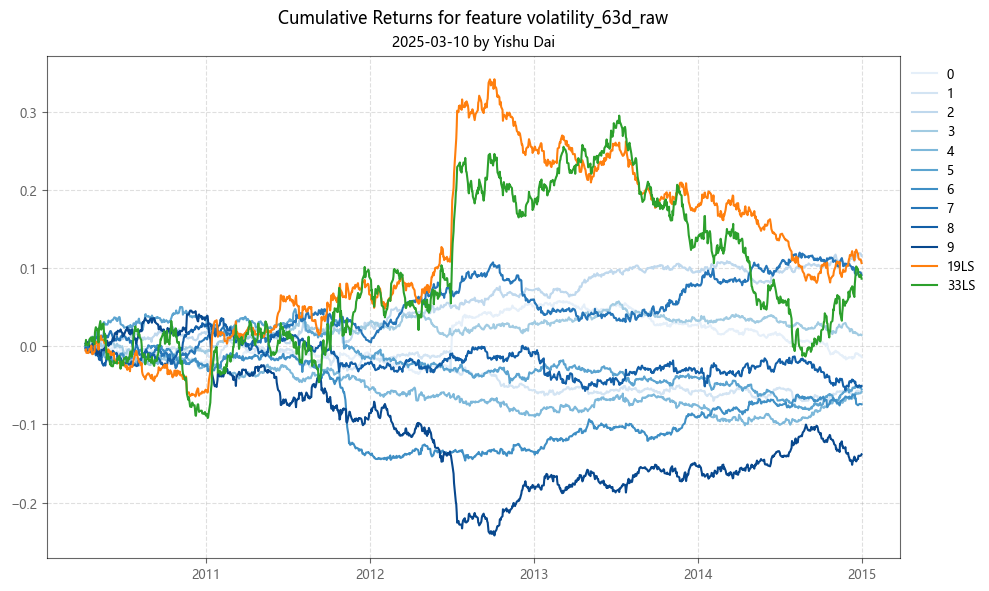

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -0.24%       -7.04%           3.13%         -0.08
1            -1.2%        -8.2%           2.42%         -0.50
2            2.37%       -2.74%           2.52%          0.94
3            0.33%       -4.07%           2.48%          0.13
4           -1.22%      -10.27%           2.84%         -0.43
5           -1.14%      -12.39%            3.1%         -0.37
6           -1.56%      -14.63%           3.45%         -0.45
7            1.93%       -6.85%           3.61%          0.53
8           -1.01%       -8.81%           4.18%         -0.24
9           -2.92%      -27.21%           5.85%         -0.50
19LS          2.4%      -19.19%           6.86%          0.35
33LS         2.28%      -23.45%          10.01%          0.23

Feature volatility_63d_resid sign: -1


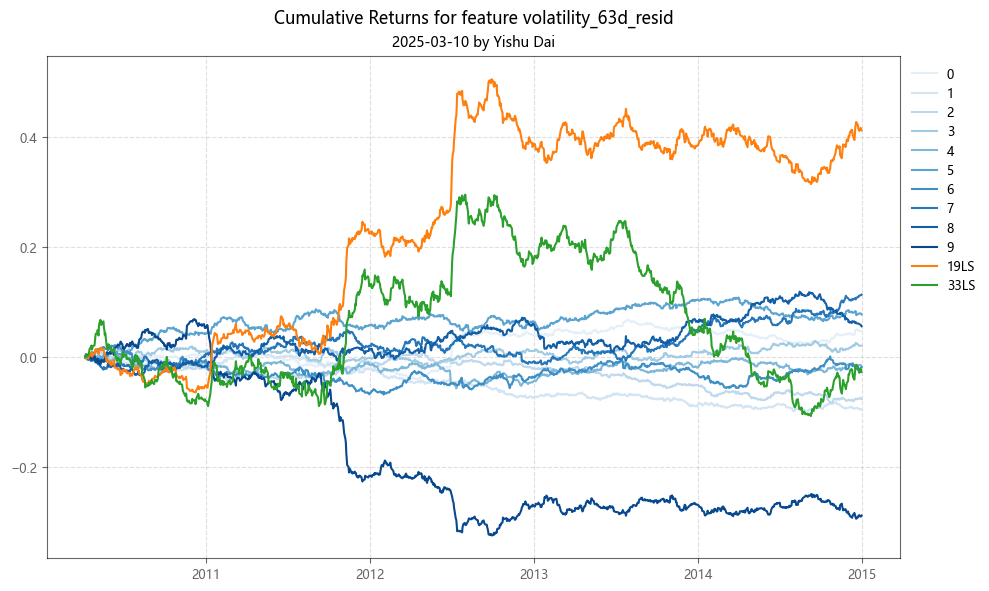

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            1.02%       -5.51%           3.07%          0.33
1           -2.07%      -10.91%           2.22%         -0.93
2           -1.64%       -9.36%           2.16%         -0.76
3            0.47%       -3.59%           2.55%          0.18
4           -0.33%       -6.11%           2.85%         -0.12
5            1.63%       -3.87%           2.85%          0.57
6           -0.33%       -8.72%           3.28%         -0.10
7            2.36%       -5.92%           3.49%          0.68
8            1.24%       -5.73%           4.04%          0.31
9           -6.73%      -36.47%           6.42%         -1.05
19LS         7.85%      -12.36%           7.34%          1.07
33LS        -0.08%      -30.55%           10.0%         -0.01

Feature hlc_ratio sign: -1


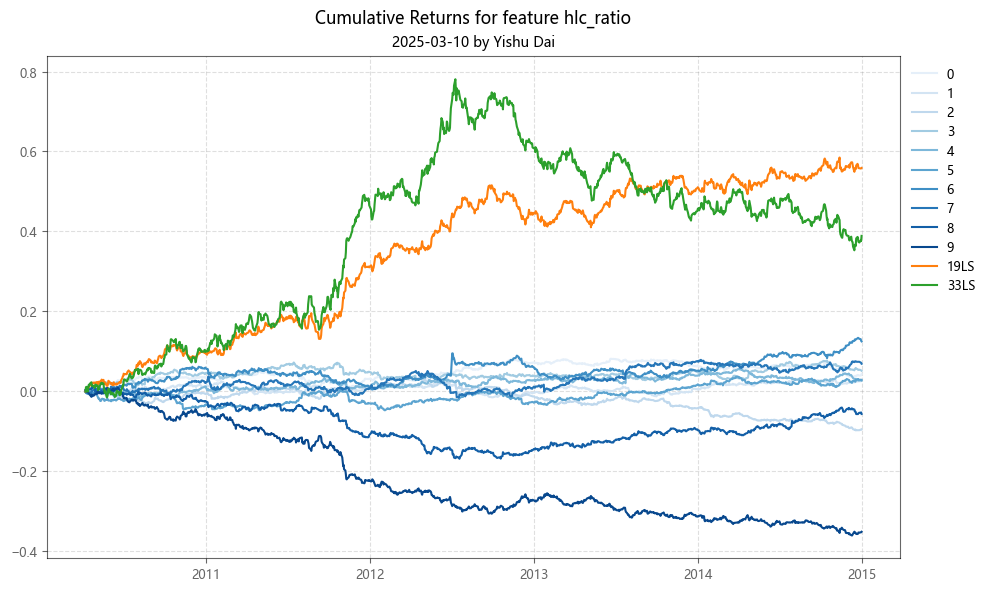

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0             0.9%       -4.16%           2.22%          0.40
1            0.57%       -3.78%           2.44%          0.23
2           -2.09%      -12.26%           2.57%         -0.81
3            1.08%       -4.04%           2.68%          0.40
4            0.58%       -3.42%           2.88%          0.20
5            0.61%       -5.25%           2.92%          0.21
6            2.59%       -6.04%           4.26%          0.61
7            1.47%       -6.29%           3.71%          0.40
8           -1.16%      -17.85%           4.18%         -0.28
9           -8.63%      -36.24%            5.8%         -1.49
19LS        10.04%       -6.83%           6.35%          1.58
33LS         7.67%       -23.4%           9.61%          0.80

Feature hlc_21mean sign: -1


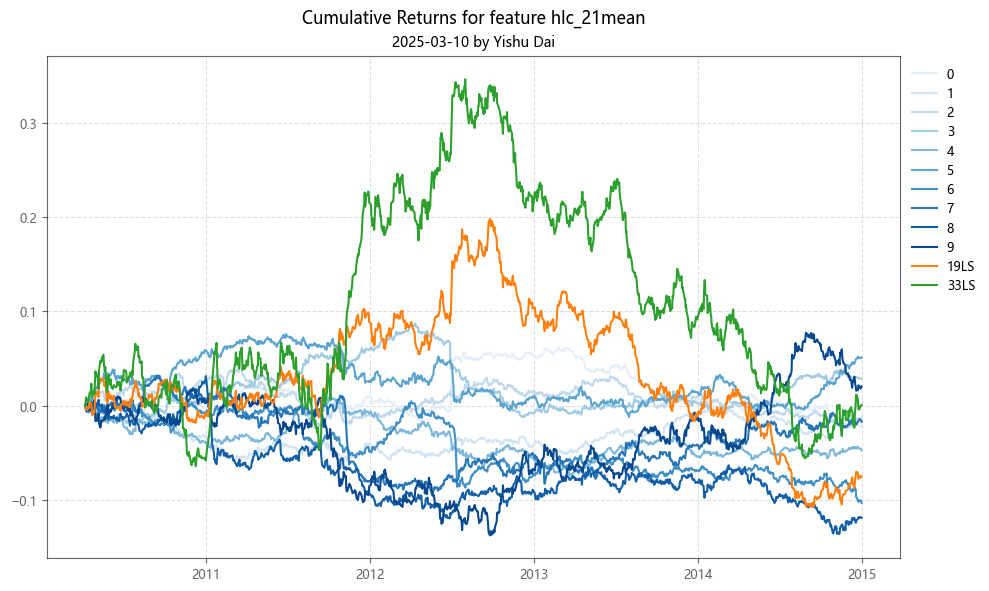

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0            -0.4%       -8.12%           3.22%         -0.12
1           -0.29%       -6.17%           2.27%         -0.13
2           -0.24%       -6.17%           2.48%         -0.10
3            0.64%       -9.07%           2.69%          0.24
4           -0.98%       -8.17%            2.7%         -0.36
5            1.11%       -8.05%           3.09%          0.36
6           -2.21%      -10.58%           3.34%         -0.66
7           -0.28%      -12.17%           3.95%         -0.07
8           -2.54%      -15.91%           4.23%         -0.60
9            0.62%      -14.97%           6.23%          0.10
19LS         -1.4%      -25.15%           7.01%         -0.20
33LS         0.54%      -29.29%          10.17%          0.05

Feature skewness_1d sign: 1


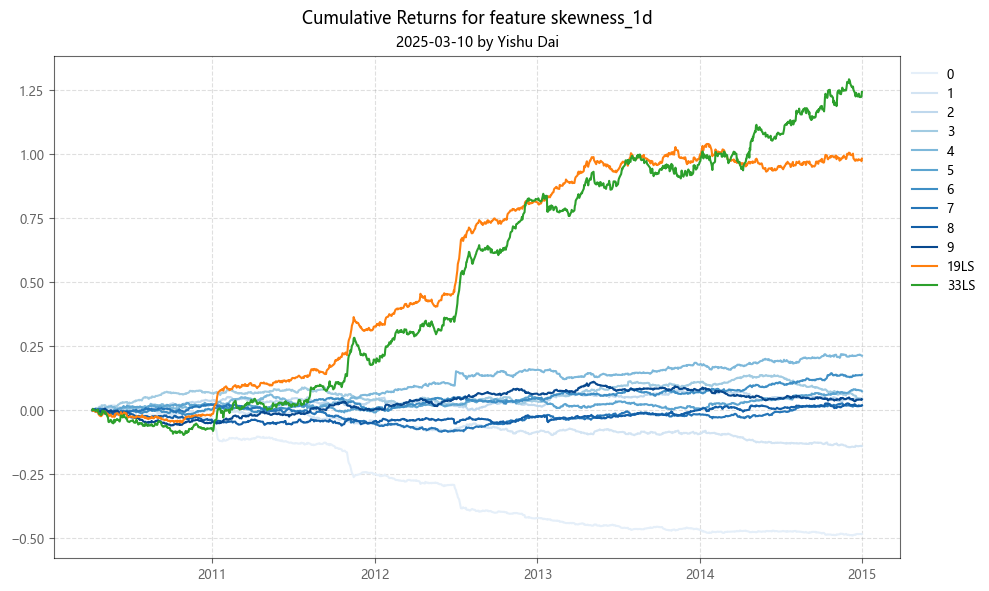

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0          -12.97%      -49.76%            4.5%         -2.88
1            -3.1%      -15.73%           3.26%         -0.95
2             0.9%       -4.88%           3.16%          0.29
3            0.95%       -8.24%           3.24%          0.29
4            4.23%        -5.3%           3.91%          1.08
5            1.56%       -5.18%           3.08%          0.51
6            2.82%        -4.9%           3.11%          0.91
7            0.44%      -10.49%           3.02%          0.15
8            0.44%       -6.36%           3.48%          0.13
9            0.94%       -6.84%           3.46%          0.27
19LS        15.73%       -5.26%           5.76%          2.73
33LS         19.1%      -10.01%           9.17%          2.08

Feature skewness_21d_resid sign: 1


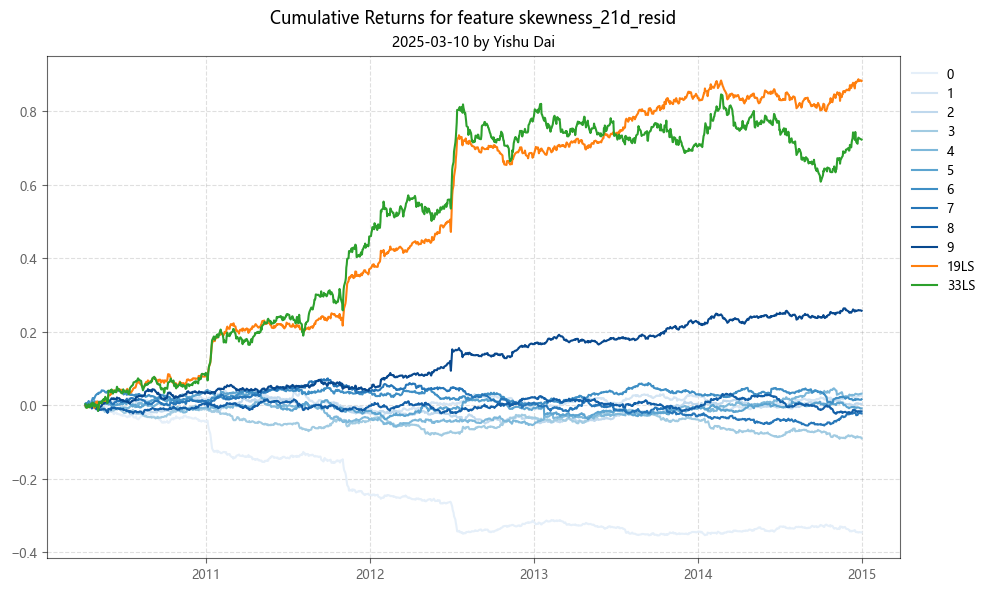

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -8.48%      -35.48%           4.39%         -1.93
1             0.6%       -6.45%           3.11%          0.19
2            0.11%        -7.1%           2.97%          0.04
3           -1.92%       -9.03%           3.29%         -0.58
4            0.71%       -6.66%           3.19%          0.22
5           -0.13%       -7.62%           3.32%         -0.04
6            0.39%       -5.04%           3.13%          0.12
7           -0.42%      -11.81%           3.26%         -0.13
8            -0.3%       -5.24%           3.33%         -0.09
9            5.04%       -2.76%           4.22%          1.19
19LS        14.52%       -4.63%            6.4%          2.27
33LS        12.66%      -12.72%           9.32%          1.36

Feature skewness_63d_resid sign: 1


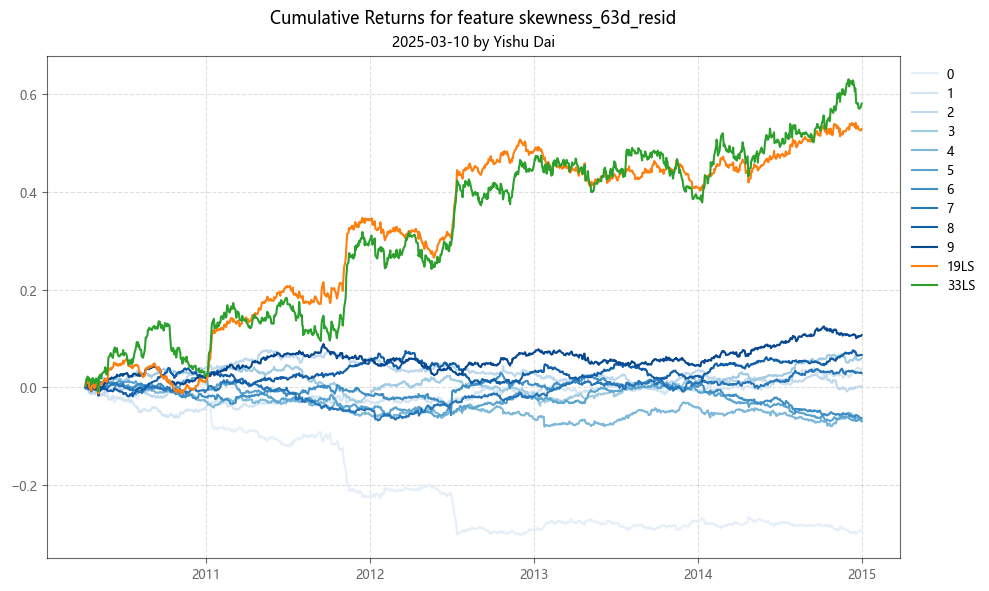

Ann. Return Max Drawdown Ann. Volatility  Sharpe Ratio
Column                                                       
0           -6.93%      -31.15%           4.78%         -1.45
1            0.82%       -7.37%           3.44%          0.24
2            0.05%       -7.73%           3.07%          0.02
3            1.29%       -7.95%           3.11%          0.42
4           -1.37%       -8.71%           3.13%         -0.44
5           -1.46%       -9.11%           2.91%         -0.50
6           -1.27%       -8.87%           3.93%         -0.32
7            0.66%       -8.38%           3.15%          0.21
8            1.42%       -6.27%           3.17%          0.45
9            2.23%       -5.81%           3.45%          0.65
19LS         9.57%        -6.8%           6.19%          1.55
33LS        10.62%       -9.79%            9.4%          1.13

In [20]:
for col in feature_columns:
    feature_output_df = factor_return_weighted(
        factor_quantile_weighted(data_features_df[['Date', 'Id', 'y', 'weight', col]], col, 'weight'),
        col, 'weight'
    )
    # If the factor has inverse effect, flip the 33LS and 19LS
    cum_ret_33LS = (1 + feature_output_df['33LS']).prod() - 1
    if cum_ret_33LS < 0:
        feature_output_df['33LS'] *= -1 # 33LS means long the first 3 quantiles, short the last 3
        feature_output_df['19LS'] *= -1 # 19LS means long the first quantile, short the last quantile
        print(f"Feature {col} sign: -1")
    else:
        print(f"Feature {col} sign: 1")
    # Plot cumulative return
    ys_cum_ret_chart(
        feature_output_df,
        log_output=False,
        title_input=f'Cumulative Returns for feature {col}',
        colors_input=ys_color_blues + ys_colors,
    )
    plt.show()
    # Show the performance matrix (annulized return, Sharp, volatility, max drawdown)
    display(ys_performance_matrix(feature_output_df, log_output=False))

Some perform well some don't

In [7]:
data_features_df.head()

Date            Id         y  y_RawReturn       weight  \
32001  2010-04-07  BBG000FQRVM3  0.002638     0.006774  7139.108908   
32002  2010-04-07  BBG000BK2F42  0.003530     0.005784  7462.472245   
32007  2010-04-07  BBG000K82ZT8  0.001201     0.006578  7910.958728   
32008  2010-04-07  BBG000C45984 -0.001238     0.001055  8143.369696   
32010  2010-04-07  BBG000BP5YT0  0.009841     0.010159  7094.342817   

       cum_return_prev5d  cum_return_prev21d  cum_return_prev63d  \
32001           0.001422            0.034361           -0.023387   
32002           0.003619           -0.009482           -0.047259   
32007           0.037750            0.048201            0.042608   
32008          -0.009881           -0.048482           -0.037630   
32010          -0.050547           -0.007906           -0.050084   

       cum_return_prev1d  cum_return_09:30_10:00  ...  volatility_1d  \
32001           594442.0               -0.000497  ...       0.000997   
32002          1665168.0                0.003878  ...       0.001961   
32007          2073333.0               -0.000596  ...       0.000916   
32008          1407575.0                0.006220  ...       0.001393   
32010          4452763.0               -0.007361  ...       0.002565   

       volatility_21d_raw  volatility_21d_resid  volatility_63d_raw  \
32001            0.008434              0.007588            0.012591   
32002            0.007136              0.007202            0.011360   
32007            0.007007              0.006336            0.009691   
32008            0.006385              0.005118            0.011803   
32010            0.017723              0.014004            0.024553   

       volatility_63d_resid  hlc_ratio  hlc_21mean  skewness_1d  \
32001              0.009887   0.010841    0.015403     0.426208   
32002              0.009421   0.021479    0.012427     0.553239   
32007              0.009481   0.019482    0.014925    -0.158661   
32008              0.006551   0.012089    0.010603     1.683957   
32010              0.017016   0.017857    0.025660    -0.797979   

       skewness_21d_resid  skewness_63d_resid  
32001           -0.689797            0.274802  
32002           -0.334565            0.967548  
32007           -0.274336           -0.480265  
32008            0.254662            0.130571  
32010            1.023195            1.635146  

[5 rows x 33 columns]

In [7]:
feature_columns.remove('cum_return_prev1d')

In [8]:
data_features_df.drop('cum_return_prev1d', axis=1, inplace=True, errors='ignore')

In [9]:
data_features_df

Date            Id         y  y_RawReturn        weight  \
32001   2010-04-07  BBG000FQRVM3  0.002638     0.006774   7139.108908   
32002   2010-04-07  BBG000BK2F42  0.003530     0.005784   7462.472245   
32007   2010-04-07  BBG000K82ZT8  0.001201     0.006578   7910.958728   
32008   2010-04-07  BBG000C45984 -0.001238     0.001055   8143.369696   
32010   2010-04-07  BBG000BP5YT0  0.009841     0.010159   7094.342817   
...            ...           ...       ...          ...           ...   
628995  2014-12-31  BBG000BPH459 -0.001028    -0.006597  37191.353834   
628996  2014-12-31  BBG000GZQ728  0.000171    -0.004183  35682.356985   
628997  2014-12-31  BBG000CKGBP2 -0.004329    -0.003201  39865.962926   
628998  2014-12-31  BBG000MM2P62 -0.005784    -0.010090  47528.344175   
628999  2014-12-31  BBG000B9XRY4 -0.009191    -0.014140  71367.013389   

        cum_return_prev5d  cum_return_prev21d  cum_return_prev63d  \
32001            0.001422            0.034361           -0.023387   
32002            0.003619           -0.009482           -0.047259   
32007            0.037750            0.048201            0.042608   
32008           -0.009881           -0.048482           -0.037630   
32010           -0.050547           -0.007906           -0.050084   
...                   ...                 ...                 ...   
628995          -0.006407           -0.033068           -0.064024   
628996          -0.009134            0.029809            0.022594   
628997           0.045775           -0.042033           -0.202298   
628998          -0.017542            0.036499           -0.017363   
628999           0.004017           -0.053946            0.067910   

        cum_return_09:30_10:00  cum_return_10:00_11:30  ...  volatility_1d  \
32001                -0.000497                0.000655  ...       0.000997   
32002                 0.003878                0.007546  ...       0.001961   
32007                -0.000596                0.002440  ...       0.000916   
32008                 0.006220                0.006343  ...       0.001393   
32010                -0.007361                0.007284  ...       0.002565   
...                        ...                     ...  ...            ...   
628995               -0.003049                0.002370  ...       0.001668   
628996               -0.003384               -0.001139  ...       0.001258   
628997                0.001776               -0.004151  ...       0.001278   
628998               -0.002767                0.003405  ...       0.001248   
628999                0.000722               -0.006991  ...       0.001509   

        volatility_21d_raw  volatility_21d_resid  volatility_63d_raw  \
32001             0.008434              0.007588            0.012591   
32002             0.007136              0.007202            0.011360   
32007             0.007007              0.006336            0.009691   
32008             0.006385              0.005118            0.011803   
32010             0.017723              0.014004            0.024553   
...                    ...                   ...                 ...   
628995            0.014683              0.008653            0.013894   
628996            0.016968              0.007245            0.013780   
628997            0.038222              0.031102            0.027634   
628998            0.016203              0.009357            0.017728   
628999            0.015871              0.008188            0.012905   

        volatility_63d_resid  hlc_ratio  hlc_21mean  skewness_1d  \
32001               0.009887   0.010841    0.015403     0.426208   
32002               0.009421   0.021479    0.012427     0.553239   
32007               0.009481   0.019482    0.014925    -0.158661   
32008               0.006551   0.012089    0.010603     1.683957   
32010               0.017016   0.017857    0.025660    -0.797979   
...                      ...        ...         ...          ...   
628995              0.008412  

In [10]:
feature_columns

['cum_return_prev5d',
 'cum_return_prev21d',
 'cum_return_prev63d',
 'cum_return_09:30_10:00',
 'cum_return_10:00_11:30',
 'cum_return_11:30_13:30',
 'cum_return_13:30_15:15',
 'relative_volume_15：30',
 'relative_volume_prev09:30_11:30',
 'relative_volume_prev11:30_13:30',
 'relative_volume_prev13:30_16:00',
 'relative_volume_09:30_10:00',
 'relative_volume_10:00_11:30',
 'relative_volume_11:30_13:30',
 'relative_volume_13:30_15:30',
 'volume_resid_return_corr',
 'volume_raw_return_corr',
 'volatility_1d',
 'volatility_21d_raw',
 'volatility_21d_resid',
 'volatility_63d_raw',
 'volatility_63d_resid',
 'hlc_ratio',
 'hlc_21mean',
 'skewness_1d',
 'skewness_21d_resid',
 'skewness_63d_resid']

In [11]:
data_features_df.iloc[452341,:]

Date                                 2014-01-02
Id                                 BBG000BDWKC5
y                                     -0.004026
y_RawReturn                           -0.018521
weight                              8648.479635
cum_return_prev5d                     -0.000363
cum_return_prev21d                     0.012078
cum_return_prev63d                    -0.006268
cum_return_09:30_10:00                -0.003119
cum_return_10:00_11:30                -0.001318
cum_return_11:30_13:30                 -0.00286
cum_return_13:30_15:15                 0.002934
relative_volume_15：30                  0.777437
relative_volume_prev09:30_11:30        0.124969
relative_volume_prev11:30_13:30        0.066228
relative_volume_prev13:30_16:00        0.237343
relative_volume_09:30_10:00            0.092511
relative_volume_10:00_11:30            0.234456
relative_volume_11:30_13:30            0.227163
relative_volume_13:30_15:30            0.223306
volume_resid_return_corr              -0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from joblib import Parallel, delayed

# 1. 加载数据集
X = data_features_df[feature_columns]
y = data_features_df['y']  # 目标变量

# 2. 数据集划分
X_train, X_test, y_train, y_test = X.loc[:452341, :], X.loc[452341:, :], y.loc[:452341], y.loc[452341:]

# 3. 训练初始模型
rf = RandomForestRegressor(n_jobs=16, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# 4. 预测
y_pred = rf.predict(X_test)

# 5. 评估初始模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"初始模型 MSE: {mse:.4f}")
print(f"初始模型 R²: {r2:.4f}")

# 6. 设定超参数范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
}

# 7. 手动遍历网格搜索并使用 tqdm 显示进度
results = []
total_combinations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])

def train_and_evaluate(n_estimators, max_depth, min_samples_split):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                               min_samples_split=min_samples_split, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'n_estimators': n_estimators, 'max_depth': max_depth, 
            'min_samples_split': min_samples_split, 'MSE': mse, 'R²': r2}

with tqdm(total=total_combinations, desc="Grid Search Progress") as pbar:
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate)(n, d, s) 
        for n in param_grid['n_estimators']
        for d in param_grid['max_depth']
        for s in param_grid['min_samples_split']
    )
    pbar.update(len(results))

# 8. 打印所有参数组合的MSE和R²
results_df = pd.DataFrame(results)
print(results_df)

# 9. 找到最佳参数
best_params = results_df.loc[results_df['MSE'].idxmin()]
print("最佳参数:", best_params[['n_estimators', 'max_depth', 'min_samples_split']].to_dict())

# 10. 使用最佳参数训练最终模型
best_rf = RandomForestRegressor(n_estimators=int(best_params['n_estimators']), 
                                max_depth=int(best_params['max_depth']), 
                                min_samples_split=int(best_params['min_samples_split']), 
                                random_state=42)
best_rf.fit(X_train, y_train)
y_best_pred = best_rf.predict(X_test)

# 11. 评估最终模型
final_mse = mean_squared_error(y_test, y_best_pred)
final_r2 = r2_score(y_test, y_best_pred)
print(f"优化后模型 MSE: {final_mse:.4f}")
print(f"优化后模型 R²: {final_r2:.4f}")



初始模型 MSE: 0.0002
初始模型 R²: -0.0038


Grid Search Progress:   0%|                                                                                                                                | 0/18 [00:00<?, ?it/s]

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from joblib import Parallel, delayed
X = data_features_df[feature_columns]
y = data_features_df['y_RawReturn']# 目标变量

# 2. 数据集划分
X_train, X_test, y_train, y_test = X.loc[:452341,:], X.loc[452341:,:],y.loc[:452341],y.loc[452341:]

# 3. 训练初始模型
rf = RandomForestRegressor(n_jobs=12,random_state=42,max_depth = 10)
rf.fit(X_train, y_train)

# 4. 预测
y_pred = rf.predict(X_test)

# 5. 评估初始模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"初始模型 MSE: {mse:.4f}")
print(f"初始模型 R²: {r2:.4f}")

# 6. 设定超参数范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10,15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 7. 网格搜索寻找最佳参数
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 8. 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 9. 使用最佳参数训练最终模型
best_rf = grid_search.best_estimator_
y_best_pred = best_rf.predict(X_test)

# 10. 评估最终模型
final_mse = mean_squared_error(y_test, y_best_pred)
final_r2 = r2_score(y_test, y_best_pred)
print(f"优化后模型 MSE: {final_mse:.4f}")
print(f"优化后模型 R²: {final_r2:.4f}")


初始模型 MSE: 0.0003
初始模型 R²: -0.0056


KeyboardInterrupt: 